# Handwritten Character Recognition

## Introduction

The idea behind the recognizing handwritten character is the feature engineering. This domain is declining as data training become center of focus to learn the problem. Although there are still many problems that need this approach. Also if one can come up with some distinctive feature, then it enables identifying that group without even training it. Yes, feature engineering is difficult and require expert knowledge. In contrast, a problem like this; where recognizing handwritten characters without stroke data and variable writing style by different users become easy if you come up with suitable features [1].

The feature can be seen as attribute shared by all independent class of characters. This is an iterative process if you can't classify one class doesn't mean that feature is bad. It depends on data and model, so brainstorming again and trying that out is the next step. We looked over features like total ink, aspect ratio, top-heaviness, and right heaviness. In this report, we will explore more feature like up-down flip, left-right flip, aspect ratio, and ink spread away from the center of mass of characters.

Later, one can come up with a different classifier to differentiate these groups. With $n$ dimensional feature space, one would need $n$ dimensional hyperplane to distinguish. Another method can be used is $k-mean$ method, which is an iterative method for finding mean (with some initial guess) of group where data points located nearest to that mean point and updating accordingly.

## Handwritten Characters

There are 1082 images containing 10 different character classes, which are $0,\ 1,\ 2,\ 7,\ 8,\ 9,\ '-',\ m,\ o,\ '.' $. Also these data are generated by different users. People have different writing styles, like dash in character $'7'$. Classify those both style as $'7'$ is challenging and might not achieve by only feature engineering. One can see sample image drawn below of handwritten character.

In [1]:
%pylab inline
from PIL import Image
import glob
import numpy as np
from randomhexcolor import randomhexcolor

Populating the interactive namespace from numpy and matplotlib


../Ex/num_png/002_20181030_vbhavsar.lettergrid.pdf.xoj__2.png


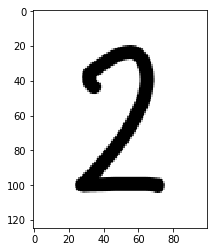

In [2]:
pngs = sorted(glob.glob('../Ex/num_png/*.png')) ####------ Update the diractory accordingly ------#####
png = pngs[34]
print(png)
img = Image.open(png)
imshow(img);

## Feature Space

### Flip

One interesting idea is to flip the images with respect to first x direction, i.e. flip up-down; and with y direction, i.e. flip left-right. Some characters like $'-',\ '.',\ 0,\ o,\ 8$ will have none to minor effect on it's shape. While all other character will have significant difference with these changes.

### Amount of ink spread away from center of mass of character

Assuming total ink spread is equal, one most difficult characters to differentiate would be $'.'$ and $0$. All the previous features like total ink, aspect ratio, top heaviness and right heaviness, flipping both ways would not clearly classify two independent group. Although one can clearly see difference in them, that from their center of mass; ink spread is varying as you go away from it. For $0$, there is big void inside and near the center of it's mass. For this feature one can find integration over entire image of product of distance and ink value.
$$F_{2} = \int_{Image} r \cdot a $$

Where, $r$ is distance from center of mass, and $a$ is intensity of ink.

## Code

I am putting entire code for all feature space and all character. Later, in discussion part images will be attached generated by same code. Although it will be focused on two type of character class, which we was interested in; with respected feature space.

=> Make nessecary change in code to generate those images according to character class, and feature space.

In [3]:
######---------- If you want selected class of character ---------######
#allpngs = sorted(glob.glob('../Ex/num_png/*.png'))
#selection = ['09','_0']
#pngs = [png for png in allpngs if png[-6:-4] in selection]
#####---------For now it's commented because we want all ---------######

pngs = sorted(glob.glob('../Ex/num_png/*.png'))
alphabet = set( [png[-6:-4] for png in pngs ] )
colormap = { item:randomhexcolor() for item in alphabet }

#colormap['09'] = 'g'
#colormap['_0'] = 'm'

colors = [ colormap[png[-6:-4]]  for png in pngs]

In [4]:
#####------------- Edit features list to what feature space you want --------#########
features = ['flip up','flip right','log aspect','ink spread away from center of mass']
#####------------------- Also Change index of F[k,0:4] array ----------------#########
n = len(pngs)
d = len(features)
F = zeros((n,d))
for k,png in enumerate(pngs):
    img = Image.open(png)
    a = array(img)
    a = a[:,:,0]
    a = 255 - a  # invert color to make ink be high values    
    a = array(a,dtype=float)
    h,w = a.shape
    
    ink = a.sum()
    if ink==0:
        print(png)
        continue
    
    # make coordinate arrays
    x = np.linspace(0,w,w,endpoint=False)
    y = np.linspace(0,h,h,endpoint=False)
    X,Y = np.meshgrid(x,y)
    
    #a>0
    xmin = X[ a>0 ].min()
    xmax = X[ a>0 ].max()
    ymin = Y[ a>0 ].min()
    ymax = Y[ a>0 ].max()
    
    we = int(xmax-xmin)
    he = int(ymax-ymin)
    
    # Only Enclouser
    en = zeros((he+1,we+1))
    for i in range(he+1):
        for j in range(we+1):
            en[i,j] = a[i+int(ymin),j+int(xmin)]
    
    # Up-down flip and check if value matches
    ud = flipud(en)
    uds = (ud!=en).sum()
    F[k,0]  = uds / (h*w)
    
    # Left-right flip and check if value matches
    lr = fliplr(en)
    lrs = (lr!=en).sum()
    F[k,1]  = lrs / (h*w)
    
    aspect = (ymax-ymin)/(xmax-xmin)
    F[k,2] = log10(aspect)
    
    xmc = (a*X).sum()/ink  # center of mass
    ymc = (a*Y).sum()/ink
    
    # Find Distance from center of mass and integrate
    dist = zeros((h,w))
    for i in range(h):
        for j in range(w):
            dist[i,j] = np.sqrt( (i-ymc)**2  + (j-xmc)**2 )
    F[k,3] = (a*dist).sum()/(h*w*255)
    #break
F[:10,:]  # first 10 rows of F

array([[ 1.58080000e-01,  1.31200000e-01,  1.70333393e-02,
         4.49728235e+00],
       [ 1.41600000e-01,  1.48800000e-01,  9.52680659e-02,
         2.66280974e+00],
       [ 1.21280000e-01,  1.07840000e-01, -8.78303552e-02,
         3.31181675e+00],
       [ 1.83200000e-01,  1.88320000e-01, -6.53086716e-03,
         3.55681774e+00],
       [ 2.72000000e-01,  3.08640000e-01,  1.47232568e-02,
         6.54704467e+00],
       [ 2.02560000e-01,  1.76160000e-01,  9.54837573e-02,
         3.38695469e+00],
       [ 2.22080000e-01,  2.26400000e-01,  8.77390497e-02,
         4.60974234e+00],
       [ 1.75040000e-01,  2.32000000e-01, -1.39357779e-02,
         7.59599135e+00],
       [ 1.58720000e-01,  2.02560000e-01, -6.73338266e-03,
         3.20691624e+00],
       [ 1.58400000e-01,  1.20320000e-01, -1.30929100e-01,
         3.12275402e+00]])

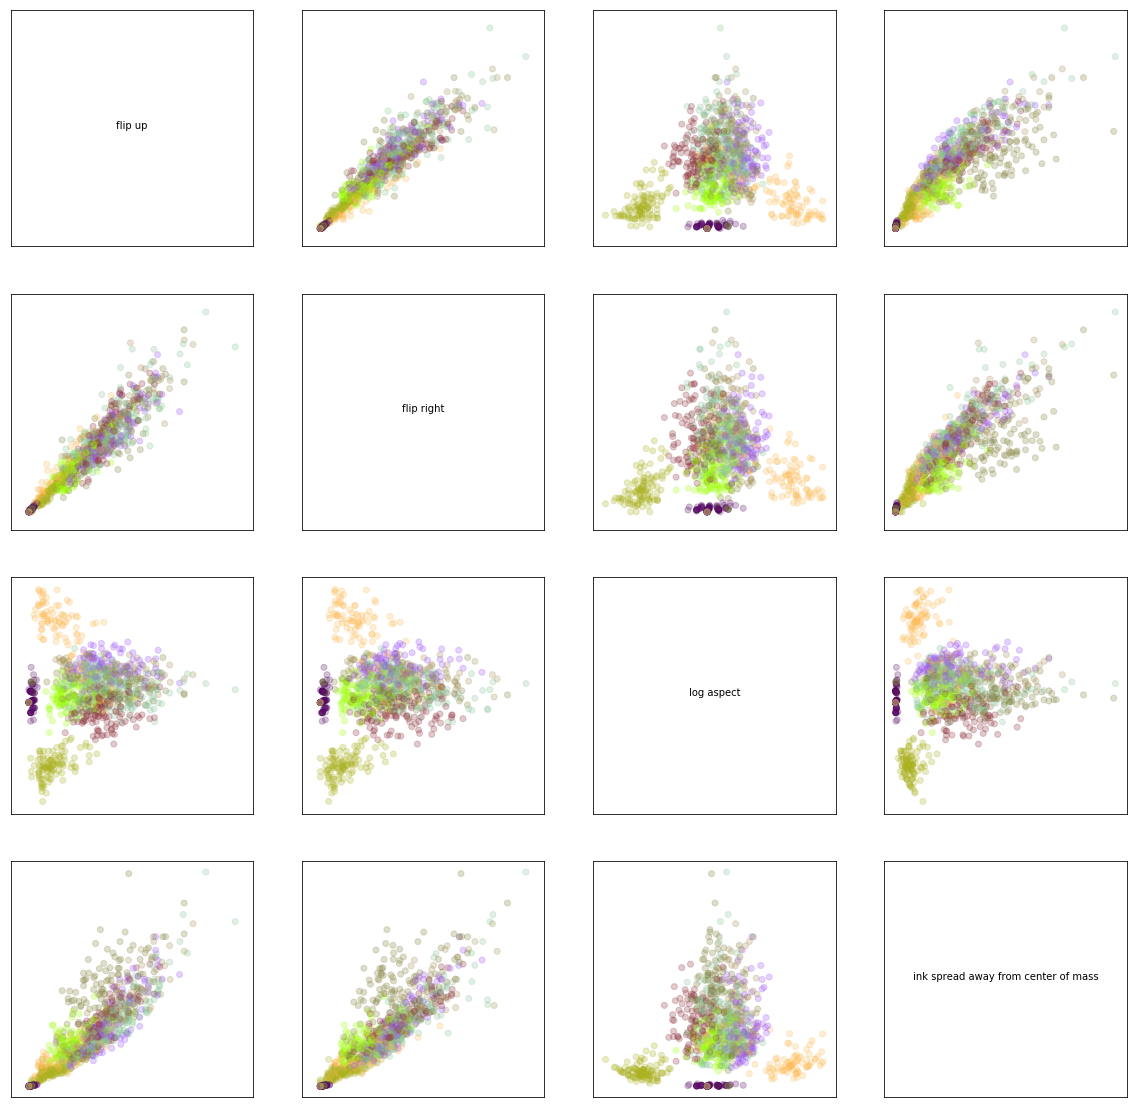

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(20,20))
for i in range(d):
    for j in range(d):
        plt.subplot(d,d,i*d+j+1)
        if i==j: 
            plt.text(.5,.5,features[i],ha='center')
        else:
            plt.scatter(F[:,j], F[:,i], color=colors, alpha=0.25)
        plt.xticks([])
        plt.yticks([])

In this all feature space and with all character, it is harder to classify each character class. But in this blob, we can clearly see some pattern. Let's see some pictures,
First - $'-'$ vs $9$, Feature space- Flip up-down and Flip left-right

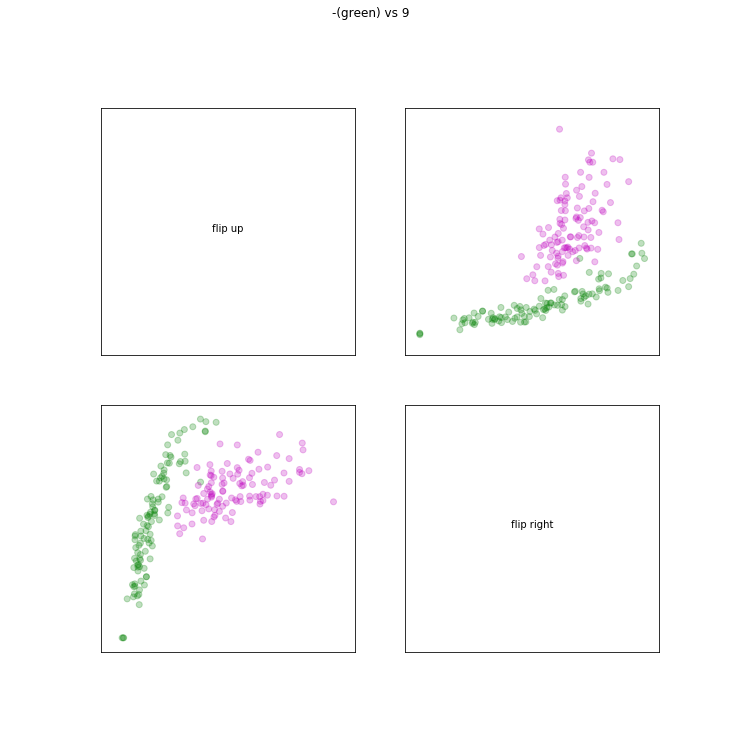

In [8]:
png = '9vs-2.png'
img = Image.open(png)
fig = plt.figure(figsize=(10,10))
ax = plt.axes([0,0,1,1], frameon=False)
imshow(img);
ax.set_title('-(green) vs 9')
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

And image for $0$ vs $'.'$ in feature space of ink spread with respect to centroid and aspect ration,

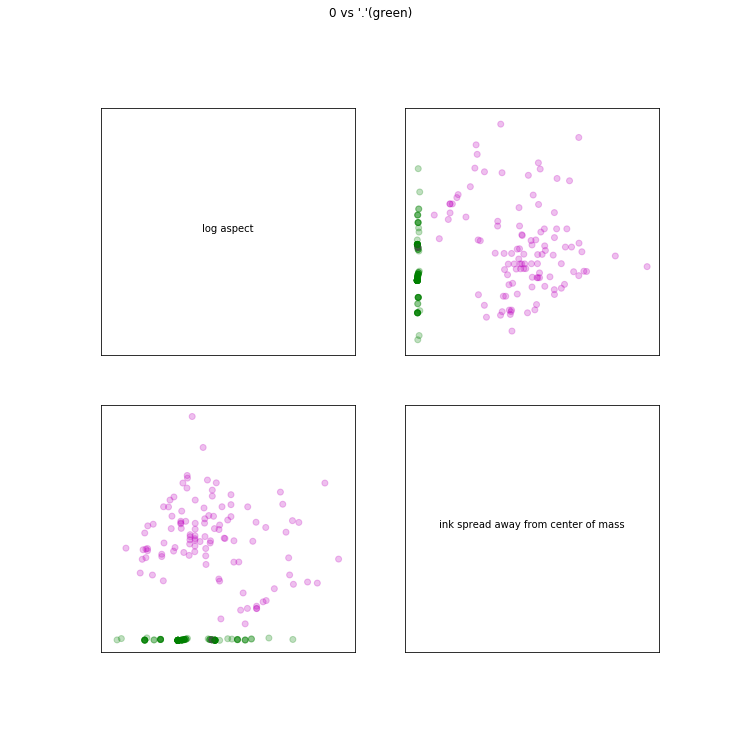

In [9]:
png = '0vs._1.png'
img = Image.open(png)
fig = plt.figure(figsize=(10,10))
ax = plt.axes([0,0,1,1], frameon=False)
imshow(img);
ax.set_title("0 vs '.'(green)")
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

We can clearly see the classifier in both the images. While flipping helped the character like $'-', 0, o$ to differentiate from other character. $'-'$ has less effect of flipping up-down and moderate effect of flipping left-right. While $9$ is clearly staying out of that blob of $'-'$.

Similarly hard to differentiate character like $'.'$ and $0$ can be classify with log aspect and ink from centroid.

## Conclusion

As discussed earlier, it is iterative process. For one independent group and one feature space it is working, but might not for other. So it need brainstorming to develop new feature spaces.
As one can see, feature engineering is still a better option for faster classifying the option. Applied machine learning is hard to figure out and require brain storming, but it can produce better result. One can develop automated feature engineering tools to simultaneously training the data, and using classifiers extracting details which can be known from feature engineering.

## references

    [1]https://en.wikipedia.org/wiki/Feature_engineering